## Using the 2nd order slaved Adams-Bashforth scheme

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression

In [2]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')
rc('font', serif='times')
#rc('font', weight='bolder')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=1)
rc("lines", linewidth=1)
rc('axes', labelsize=16)
rc("axes", linewidth=1)
rc('xtick', labelsize=16)
rc('ytick', labelsize=16)
rc('legend', fontsize=16)
rc('ytick', right='True',direction= 'in')
rc('xtick', top='True',direction= 'in')
rc('xtick.major', pad=8)
rc('ytick.major', pad=8)
rc('xtick.major', size=8)
rc('ytick.major', size=8) 
rc('xtick.minor', size=7)
rc('ytick.minor', size=7)

def set_tick_sizes(ax, major, minor):
    for l in ax.get_xticklines() + ax.get_yticklines():
        l.set_markersize(major)
    for tick in ax.xaxis.get_minor_ticks() + ax.yaxis.get_minor_ticks():
        tick.tick1line.set_markersize(minor)
        tick.tick2line.set_markersize(minor)
    ax.xaxis.LABELPAD=10.
    ax.xaxis.OFFSETTEXTPAD=10.

### GOY Shell model equations without forcing

$\partial_tU_n+\nu k_n^2U_n = ik_n\left[U_{n+1}U_{n+2}-\frac{1}{4}U_{n-1}U_{n+1}-\frac{1}{8}U_{n-1}U_{n-2}\right]^*$

In [3]:
def g(uvec, t, n):
    '''
    uvec: complex vector representing u_n at a given time t
    n: shell number
    Returns the non-linear term according to the GOY system of equations
    '''
    
    U = uvec[:]
    
    if n==0:
        NLT = U[1]*U[2]
    elif n==1:
        NLT = U[2]*U[3]-(U[0]*U[2]/4.)
    elif n==N-2:
        NLT = -(U[N-3]*U[N-1]/4.)-(U[N-3]*U[N-4]/8.) 
    elif n==N-1:
        NLT = -U[N-2]*U[N-3]/8.
    else:
        NLT = U[n+1]*U[n+2]-(U[n-1]*U[n+1]/4.)-(U[n-1]*U[n-2]/8.)
    
    return 1j*k[n]*NLT.conjugate()

In [4]:
def slavedAdBash(t0, tn, n, y0):
    '''
    t0: initial time
    tn: final time
    n : number of time slices
    y0: initial configuration vector
    y : returns the configuration
    '''
    dt = abs(tn-t0)/n
    t = np.linspace(t0,tn,n+1)
    y = np.zeros([n+1,len(y0)],dtype=complex)
    y[0] = y0
    
    for i in range(0,n): #i denotes the time slice  
        for j in range(len(y0)):   #j denotes the shell
            ex = np.exp(-nu*k[j]*k[j]*dt)
            y[i+1][j] = ex*y[i][j]+(1.5*g(y[i],t[i],j)-0.5*g(y[i-1],t[i-1],j))*(1-ex)/(nu*k[j]*k[j])
    return y

### Driver code

In [31]:
start_time = time.time()
Nr = 100 #number of realizations
N = 22 #number of shells

nu = 10**(-7) #kinematic viscosity
k0 = 1./16.
u0 = 0.5

n = 10**5 #number of time slices
t0 = 0 #initial time
tn = 25 #final time
t = np.linspace(t0,tn,n+1)

#initializing k vector
k=[]
for i in range(1,N+1):
    k.append(k0*(2**i))

uf = []
ucomp = []
for _ in range(Nr):
    #initialization of the vector u
    ui = []
    phi_u = np.random.uniform(-np.pi,np.pi,N)
    for i in range(N):
        kn = k[i]
        ui.append(u0*kn**(-1./3.)*np.exp(-kn*kn+1j*phi_u[i]))

    #Solving the N differential equations using slaved Adams-Bashforth
    un = slavedAdBash(t0,tn,n,ui)
    
    #every element of uf is a realization
    uf.append(np.abs(un))
    ucomp.append(un)

#every element i of u gives the configuration at ith time averaged over all realizations
u = np.mean(uf,axis = 0)
uc = np.mean(ucomp,axis = 0)

end_time = time.time()
print('Time taken = ', end_time-start_time)

Time taken =  3159.081191301346


### Energy and enstrophy plots

In [32]:
En = np.zeros(n+1) #energy at given time summed over all shells
Ens = np.zeros(n+1)#enstrophy at a given time summed over all shells
for i in range(n+1):
    for j in range(N):
        enu = u[i][j]*u[i][j]
        ens = enu*k[j]*k[j]
        Ens[i]+=ens
        En[i]+=enu                

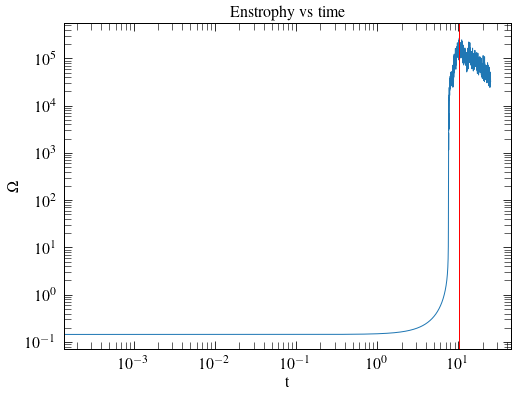

The max value of enstrophy is at t = 10.303500


In [33]:
Ens_m_id = np.argmax(Ens)
tmax = t[Ens_m_id]
plt.figure(figsize = (8,6))
plt.loglog(t,Ens)
plt.title('Enstrophy vs time', size = 16)
plt.xlabel('t')
plt.ylabel(r'$\Omega$')
plt.axvline(tmax,c = 'r')
#plt.savefig('enstrophy_GOY.jpg')
plt.show()
print('The max value of enstrophy is at t = %f'%tmax)

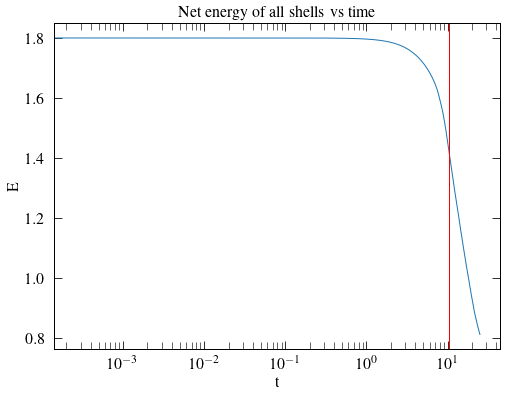

In [34]:
plt.figure(figsize = (8,6))
plt.semilogx(t,En)
plt.title('Net energy of all shells vs time',size = 16)
plt.xlabel('t')
plt.ylabel('E')
plt.axvline(tmax,c='r')
#plt.savefig('totEnergy_GOY.jpg')
plt.show()

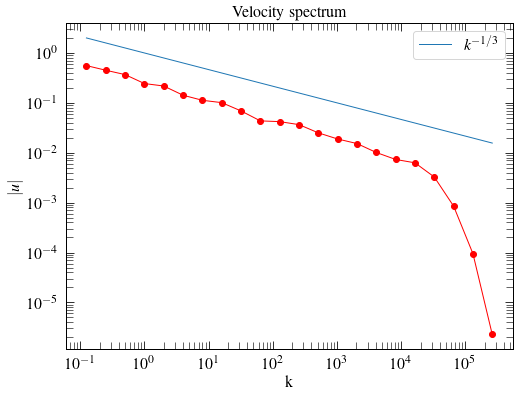

In [35]:
plt.figure(figsize = (8,6))
plt.title('Velocity spectrum',size = 16)
plt.loglog(k,u[-1],c = 'r',marker = 'o')
yy = []
for i in range(len(k)):
    yy.append(k[i]**(-1/3))
plt.loglog(k,yy,label = r'$k^{-1/3}$')
plt.xlabel('k')
plt.ylabel(r'$|u|$')
plt.legend()
#plt.savefig('velocitySpec_GOY.jpg')
plt.show()


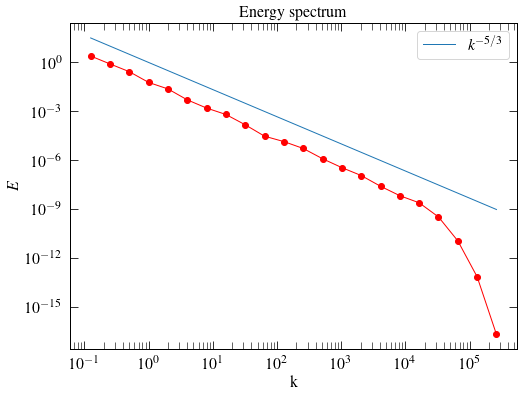

In [36]:
plt.figure(figsize = (8,6))
plt.title('Energy spectrum',size = 16)
yy2 = []
enn = []
for i in range(len(k)):
    yy2.append(k[i]**(-5/3))
    enn.append(u[-1][i]*u[-1][i]/k[i])
plt.loglog(k,yy2,label = r'$k^{-5/3}$')
plt.loglog(k,enn,c = 'r', marker = 'o')
plt.xlabel('k')
plt.ylabel(r'$E$')
plt.legend()
#plt.savefig('energySpec_GOY.jpg')
plt.show()

### Structure functions

In [61]:
pvec = [1,2,3,4,5,6,7,8]
s = []
for p in pvec:
    st = []
    for v in u[-1]:
        st.append(pow(v,p))
    s.append(st)

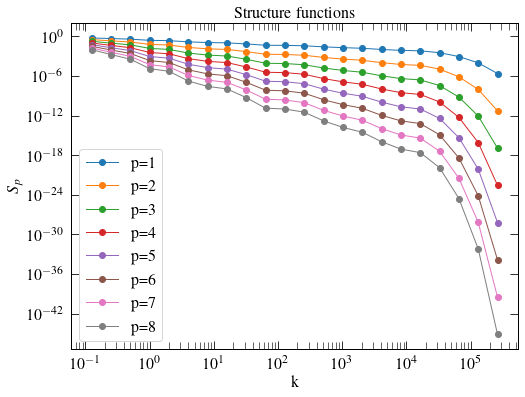

In [62]:
plt.figure(figsize = (8,6))
plt.title('Structure functions',size = 16)
for i,p in enumerate(pvec):
    plt.loglog(k,s[i],marker = 'o',label = 'p=%d'%p)
plt.xlabel('k')
plt.ylabel(r'$S_p$')
plt.legend()
#plt.savefig('strucFunc_GOY.jpg')
plt.show()

Modified structure functions in inertial range

In [63]:
sigma = []
R = len(uc[-1])
ux = uc[-1]
for p in pvec:
    st = []
    for i in range(2,R-5):
        ss = abs(np.imag(ux[i+2]*ux[i+1]*ux[i]+0.25*ux[i-1]*ux[i]*ux[i+1]))
        st.append(pow(ss,p/3.))
    sigma.append(st)

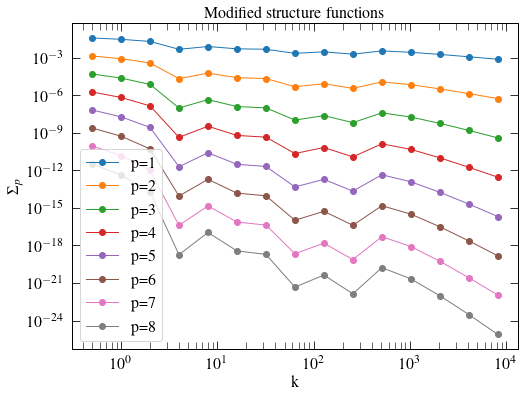

In [64]:
plt.figure(figsize = (8,6))
plt.title('Modified structure functions',size = 16)
for i,p in enumerate(pvec):
    plt.loglog(k[2:-5],sigma[i],marker = 'o',label = 'p=%d'%p)
plt.xlabel('k')
plt.ylabel(r'$\Sigma_p$')
plt.legend()
#plt.savefig('modif_strucFunc_GOY.jpg')
plt.show()

### Finding the Exponents

In [75]:
k41pred = []
she_leveque = []
for p in pvec:
    k41pred.append(p/3)
    sl = p/9.+2*(1-(2./3.)**(p/3.))
    she_leveque.append(sl)

In [70]:
x = np.log(k[2:-5])
x = np.array(x).reshape((-1,1))
slope = []
for i in range(len(sigma)):
    y = np.array(np.log(sigma[i]))
    model_coeff = LinearRegression().fit(x,y).coef_
    slope.append(model_coeff[0])
print(slope)

[-0.33844660480136857, -0.676893209602737, -1.015339814404106, -1.353786419205474, -1.692233024006843, -2.030679628808212, -2.36912623360958, -2.707572838410948]


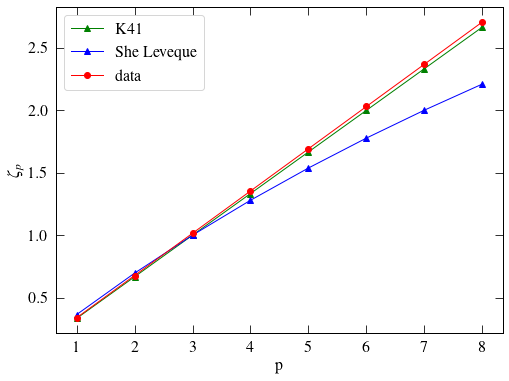

In [82]:
plt.figure(figsize = (8,6))
plt.plot(pvec,k41pred,marker = '^',c = 'g',label = 'K41')
plt.plot(pvec,she_leveque,marker = '^', c= 'b', label = 'She Leveque')
plt.plot(pvec,np.abs(slope),marker = 'o',c = 'r',label = 'data')
plt.xlabel('p')
plt.ylabel(r'$\zeta_p$')
plt.legend()
plt.show()